<a href="https://colab.research.google.com/github/rubanzasilva/steel_plate_defect_prediction/blob/main/ps_s04_e03_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F68699%2F7659021%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T190106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59d139535f1af478c2be82072bce1f9d8ae76a338d2f231760147d1208dd45b7619497973f7cdac8a74afa813926e10a779790e215b3d12f6d3d9d7887acbd517452421d3ccf44b76958fa23d0142d7710cf770f1fb9bd6daef82b07de77615857be6c14c69d28a2ec1b4ca94bc7e0c830ca3daec3e9660526333c64ed0e81061afe94d6038e634c609664a3baf3cdd1c2b1025d259cabce75cfa84ed815723eb024c362f6bc7ab36fbf38eb5f8e9e78215ab759bd1cb2f9c11fa4be6de4212315d67f6300b297b96a9f50261c8d93d2c9dd449c4f409792ee460914c0f8df2dcd686ac3c25c449e19cc04fec27ed285c2bb3e73d36f9b0513f0c2220b479076'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


### Imports

If you dont have the fastai library installed, uncomment the lines with pip install fastbook to install all the dependencies we shall need.

In [ ]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

In [ ]:
!ls

state.db


Set random seed for reproducibility.

In [ ]:
set_seed(42)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [ ]:
!ls /kaggle/input/playground-series-s4e3

sample_submission.csv  test.csv  train.csv


In [ ]:
path = Path('/kaggle/input/playground-series-s4e3')
path

Path('/kaggle/input/playground-series-s4e3')

Problem approach

Create an effective validation set

Iterate rapidly to find changes which improve the validation set

In [ ]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')

In [ ]:
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [ ]:
sub_df.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,19222,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,19223,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
test_df.shape,train_df.shape

((12814, 28), (19219, 35))

In [ ]:
test_df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object')

In [ ]:
train_df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [ ]:
y_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [ ]:
cont_names, cat_names = cont_cat_split(train_df,dep_var=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [ ]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names= y_names,
                  # y_block = CategoryBlock,
                   splits=splits)

In [ ]:
to.xs.iloc[:2]

,TypeOfSteel_A300,TypeOfSteel_A400,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
11340,2,1,0.313684,-1.340465,-1.486213,-0.721962,-0.722446,-0.424463,-0.376291,-0.406758,...,-0.399167,0.144737,0.062912,0.842607,-0.567453,-0.230852,-0.068816,0.865095,-1.070323,-0.595141
2094,1,2,-1.356317,1.151727,1.173838,2.113786,2.123421,-0.270663,-0.348350,-0.276931,...,-0.373550,-0.409438,0.761681,0.842607,0.536130,0.064983,0.412268,0.324788,-0.468295,1.215455


In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
dls.show_batch()

,TypeOfSteel_A300,TypeOfSteel_A400,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,1,0,17982.000226,507.000007,512.999994,1.620649e+06,1.620667e+06,113.999989,17.000000,14.999999,13986.995683,105.000000,140.0,1687.999994,70.000000,0.0036,0.3667,0.6667,0.0077,0.7647,1.0000,1.000000e+00,2.0569,1.1139,1.1761,3.333000e-01,-0.0548,0.3097,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,6071.000139,1327.000014,1332.000010,1.060291e+06,1.060313e+06,55.000038,20.999999,13.999999,4108.000022,86.000000,111.0,1687.999994,70.000000,0.0192,0.2917,0.5714,0.0044,0.3636,1.0000,1.000000e+00,1.7404,0.7782,1.1461,4.286000e-01,-0.1880,0.2195,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,13944.999971,38.999985,216.000022,2.896951e+06,2.897015e+06,6421.999874,278.000005,134.000000,670952.022029,41.999998,125.0,1358.000002,40.000001,0.0574,0.4603,0.3864,0.1289,0.6295,0.4925,-1.942094e-08,3.8084,2.2430,1.8325,-6.136000e-01,-0.1851,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,8832.000038,52.000006,91.999997,6.825898e+04,6.828804e+04,313.000012,52.000001,41.000000,39555.995577,92.000000,133.0,1354.000004,70.000000,0.1064,0.6098,0.8947,0.0242,0.5165,0.5366,-1.942094e-08,2.4969,1.6128,1.3424,-1.053000e-01,-0.1166,0.9681,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,9931.000006,1328.999997,1339.000025,3.485560e+05,3.485680e+05,139.999960,18.999999,28.999999,16070.002307,110.000000,133.0,1363.999996,199.999996,0.7699,0.5185,0.8571,0.0118,0.8947,0.5185,1.000000e+00,2.1461,1.2041,1.1461,1.429000e-01,-0.0786,0.3601,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,1,1165.000239,630.000003,649.000001,2.339660e+06,2.339663e+06,54.000005,9.000002,9.000001,6935.994947,111.000001,142.0,1387.000000,40.000001,0.6333,0.2778,0.8889,0.0058,0.8889,1.0000,1.000000e+00,1.7324,0.9031,0.9542,1.111000e-01,-0.0236,0.1773,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0,1,8295.000025,1465.000030,1486.000029,2.601240e+05,2.601360e+05,54.000005,27.000002,12.000002,7483.998348,115.999999,140.0,1651.999996,40.000001,0.2668,0.5833,0.4000,0.0132,0.5556,0.5833,-1.942094e-08,1.7324,1.2553,0.8451,-6.000001e-01,-0.0041,0.2621,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,1,11864.000002,40.999969,211.999971,1.469856e+06,1.469884e+06,6881.999970,275.999995,131.000000,674367.004897,41.000001,124.0,1359.999997,40.000001,0.0604,0.4272,0.3829,0.1274,0.6604,0.4574,-1.942094e-08,3.8236,2.2380,1.8451,-6.171000e-01,-0.1851,1.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,0,13140.000028,1064.999993,1078.000003,5.303273e+06,5.303295e+06,108.000013,18.999999,14.999999,12304.000938,97.000000,133.0,1363.999996,80.000000,0.7094,0.3536,1.0000,0.0089,0.6842,0.8667,5.000000e-01,2.0334,1.1139,1.1139,-2.434815e-09,-0.1094,0.2914,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1,0,18436.999806,40.999969,216.000022,1.853169e+06,1.853339e+06,654.999986,76.000000,133.000000,677554.017510,38.000001,124.0,1355.999999,80.000000,0.0605,0.4331,0.3771,0.1291,0.5369,0.5149,-1.942094e-08,2.8142,2.2430,1.8129,-6.229000e-01,-0.1902,1.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
learn = tabular_learner(dls, metrics=RocAucMulti())

SuggestedLRs(slide=0.019054606556892395, valley=0.0005754399462603033)

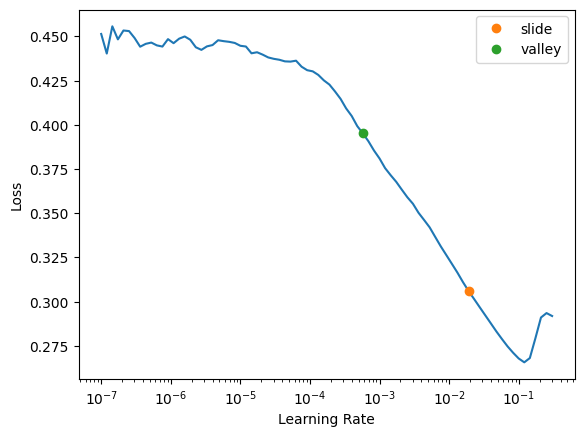

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
#learn.fit_one_cycle(15, slice(0.0005, 0.019))
learn.fit_one_cycle(15, 0.014)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.086174,0.082747,0.822724,00:02
1,0.083556,0.082568,0.814651,00:02


KeyboardInterrupt: 

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
nn_preds = learn.get_preds(dl=dl)
nn_preds

In [ ]:
nn_preds_x = learn.get_preds()[0]
nn_preds_x

In [ ]:
nn_preds_x.shape

In [ ]:
target_preds = preds[0]

In [ ]:
target_preds.shape

In [ ]:
#targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [ ]:
#test_df[targets] = target_preds

#test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

#sub = pd.read_csv('submission.csv')
#sub.head()

In [ ]:
#test_df.to_csv('submission.csv', columns=targets, index=False)

In [ ]:
#sub = pd.read_csv('submission.csv')
#sub.head()

In [ ]:
#!kaggle competitions submit -c playground-series-s4e3 -f submission.csv -m "fastai baseline, adding lr fron lr finder"

Ensembling

Neural Network Ensemble

In [ ]:
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
dl = learn.dls.test_dl(test_df)

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(12, 0.014)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
#targets =['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
#test_df[targets] = ens_preds

#test_df.to_csv('submission.csv', columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], index=False)

ens_sub = pd.read_csv('submission.csv')
ens_sub.head()

In [ ]:
!ls

In [ ]:
!kaggle competitions submit -c playground-series-s4e3 -f submission.csv -m "fastai baseline, adding neural network ensemble"

In [ ]:
sub_df = pd.read_csv(path/'sample_submission.csv')

Random Forests

In [ ]:
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
from fastai.tabular.all import *

from fastai.imports import *
np.set_printoptions(linewidth=130)

# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path
import os
import seaborn as sns
import numpy as np
from numpy import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from ipywidgets import interact



matplotlib.rc('image', cmap='Greys')

random.seed(42)

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path = Path('/kaggle/input/playground-series-s4e3')
path

train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sub_df = pd.read_csv(path/'sample_submission.csv')

y_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

cont_names, cat_names = cont_cat_split(train_df,dep_var=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names= y_names,
                  # y_block = CategoryBlock,
                   splits=splits)

#X_train, y_train = to.train.xs, to.train.ys.values.ravel()
#X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
#mean_absolute_error(y_test, rf.predict(X_test))

roc_auc_score(y_test, rf.predict(X_test))

In [ ]:
rf_preds = rf.predict(X_test)

In [ ]:
rf_preds.shape

In [ ]:
y_train

Kaggle Submission

In [ ]:
import pandas as pd

# Assuming `rf` is your trained model and `X_test` is your test data
# Make predictions
preds = rf.predict(X_test)

# Assuming `test_df` is your test DataFrame and it has an 'id' column
# Create a DataFrame for the submission
#sub_df = pd.DataFrame(preds, columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
#sub_df['id'] = test_df['id'] # Add the 'id' column from the test data

# Reorder the columns to match the submission format
#sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
#sub_df.to_csv('rf_submission.csv', index=False)


In [ ]:
preds.shape

(3843, 7)

In [ ]:
!ls

Neural Network + Random Forest

In [ ]:
avgs = (nn_preds_x + rf_preds) / 2
avgs

In [ ]:
!ls

In [ ]:
import pandas as pd

# Assuming `rf` is your trained model and `X_test` is your test data
# Make predictions
#preds = rf.predict(X_test)

# Assuming `test_df` is your test DataFrame and it has an 'id' column
# Create a DataFrame for the submission
sub_df = pd.DataFrame(avgs, columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'])
sub_df['id'] = test_df['id'] # Add the 'id' column from the test data

# Reorder the columns to match the submission format
sub_df = sub_df[['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

# Save the submission DataFrame as a CSV file
sub_df.to_csv('submission.csv', index=False)


In [ ]:
# Assuming `sub_df` is your DataFrame that needs the 'id' column converted
# Convert 'id' column to Int32 by rounding the floating-point numbers
#submission_df['id'] = submission_df['id'].round().astype('Int32')

# Now, 'id' column is of type Int32
#print(submission_df['id'].dtype)


In [ ]:
!ls

In [ ]:
#sub_df = pd.read_csv(path/'sample_submission.csv')
sub_tree = pd.read_csv('submission.csv')

In [ ]:
sub_tree.shape

In [ ]:
sub_tree.shape

In [ ]:
sub_tree.info()

In [ ]:
sub_df

In [ ]:
print(sub_df['id'].dtype)

In [ ]:
#target_preds = preds[0]
#target_preds

In [ ]:
!ls